In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBRegressor


import shap


df = pd.read_csv(r'C:\Users\urvi9\Downloads\Medical_Cost\insurance.csv')
df


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Data Ingestion and Data cleaning

In [3]:
print("Dataset Shape:", df.shape)

Dataset Shape: (1338, 7)


In [4]:
print("Null values per column:")
print(df.isnull().sum())

Null values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [5]:
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")
df = df.drop_duplicates()

Duplicate rows: 1


In [6]:
print("\nData types:")
print(df.dtypes)


Data types:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


In [7]:
def remove_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filtering out outliers
    filtered_df = dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]
    print(f"{column}: Removed {len(dataframe) - len(filtered_df)} outliers")
    return filtered_df

In [8]:
numeric_cols = ['age', 'bmi', 'children', 'charges']
for col in numeric_cols:
    df = remove_outliers_iqr(df, col)

print("Cleaned dataset shape:", df.shape)

age: Removed 0 outliers
bmi: Removed 9 outliers
children: Removed 0 outliers
charges: Removed 138 outliers
Cleaned dataset shape: (1190, 7)


Exploratory Data Analysis (EDA)


In [9]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)


In [10]:
#Statistical Summary
print("📊 Summary Statistics:")
display(df.describe(include='all'))

📊 Summary Statistics:


,age,sex,bmi,children,smoker,region,charges
count,1190.000000,1190,1190.000000,1190.000000,1190,1190,1190.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,female,NaN,NaN,no,northwest,NaN
freq,NaN,610,NaN,NaN,1054,304,NaN
mean,39.027731,NaN,29.993147,1.088235,NaN,NaN,9908.046614
std,14.050554,NaN,5.873027,1.216558,NaN,NaN,7186.405555
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,26.000000,NaN,25.800000,0.000000,NaN,NaN,4418.591062
50%,39.000000,NaN,29.700000,1.000000,NaN,NaN,8378.605575
75%,51.000000,NaN,33.770000,2.000000,NaN,NaN,12955.356300


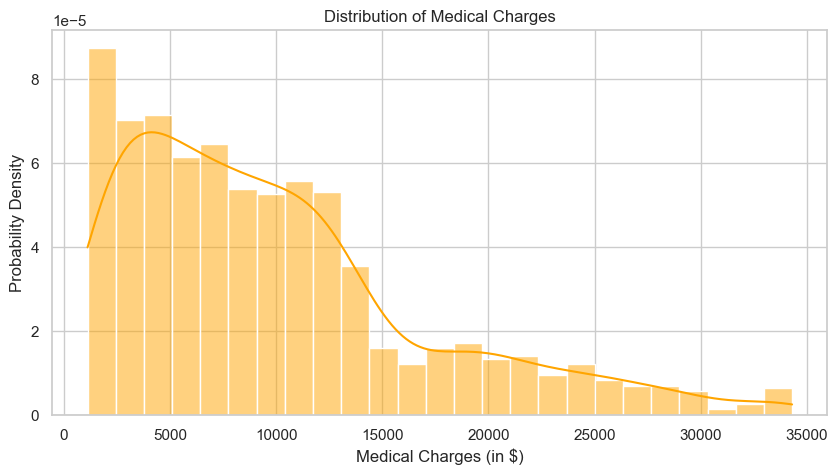

In [11]:
#Target Variable Distribution (Charges)
plt.figure()
sns.histplot(df['charges'], bins=25, stat='density',color='orange', kde=True, label='Histogram')
plt.title("Distribution of Medical Charges")
plt.xlabel("Medical Charges (in $)")
plt.ylabel("Probability Density")
plt.show()

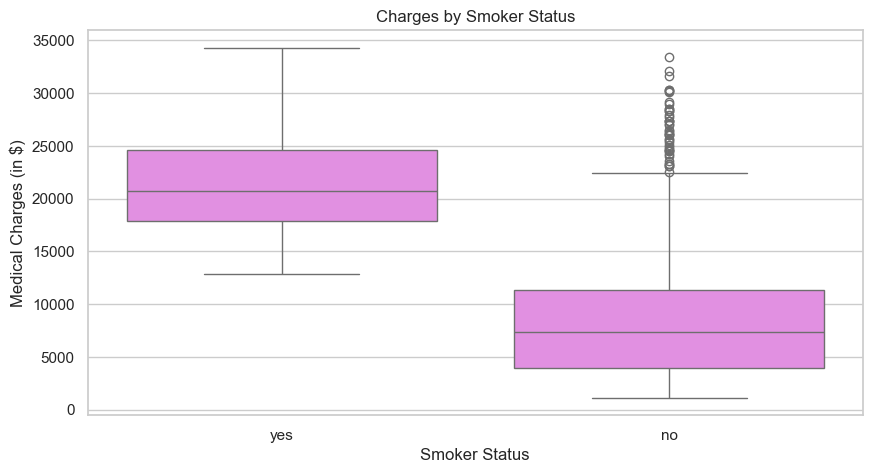

In [12]:
#Boxplot of Charges by Smoker
plt.figure()
sns.boxplot(x='smoker', y='charges', data=df, color='violet')
plt.title("Charges by Smoker Status")
plt.ylabel("Medical Charges (in $)")
plt.xlabel("Smoker Status")
plt.show()

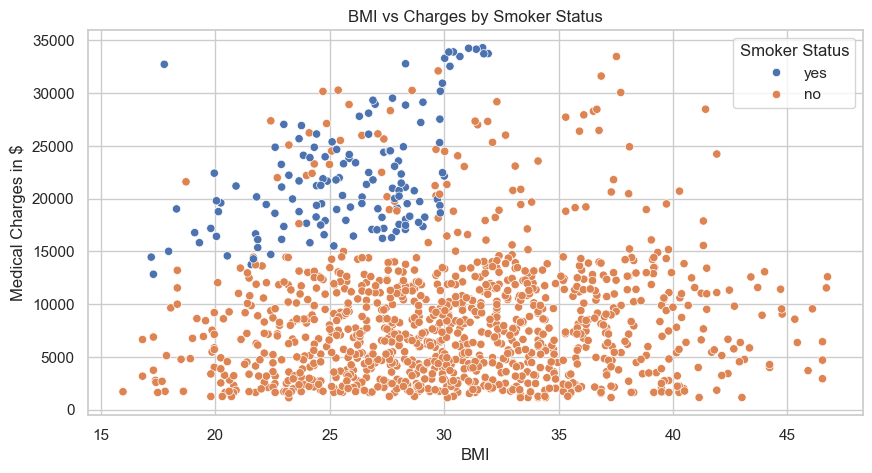

In [13]:
#Charges vs. BMI Scatterplot (highlighting smoker)
plt.figure()
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df)
plt.title("BMI vs Charges by Smoker Status")
plt.xlabel("BMI")
plt.ylabel("Medical Charges in $")
plt.legend(title='Smoker Status')
plt.grid(True)
plt.show()

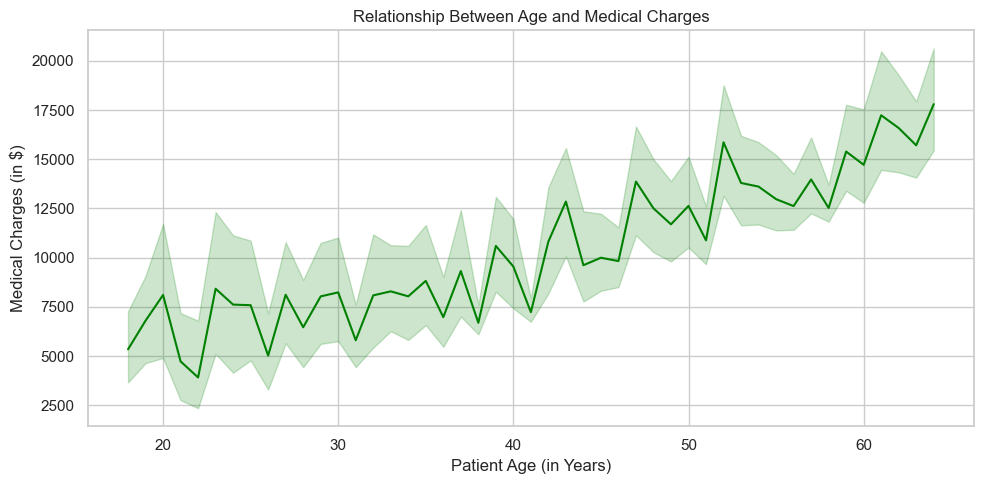

In [14]:
#Charges vs. Age
plt.figure()
sns.lineplot(x='age', y='charges', data=df.sort_values('age'), color='green')
plt.title("Relationship Between Age and Medical Charges")
plt.xlabel("Patient Age (in Years)")
plt.ylabel("Medical Charges (in $)")
plt.grid(True)
plt.tight_layout()
plt.show()

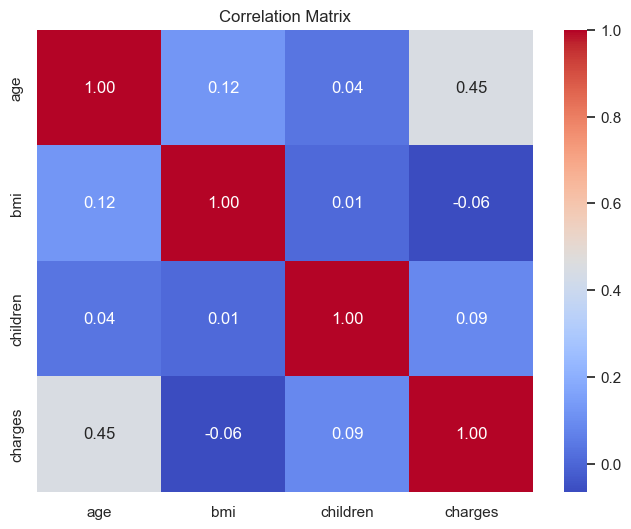

In [15]:
# F. Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [16]:
#Average Charges by Region
print("📍 Average Charges by Region:")
display(df.groupby("region")["charges"].mean().sort_values(ascending=False))


📍 Average Charges by Region:


region
northeast    10740.681074
northwest    10392.290654
southeast     9541.690097
southwest     8933.687846
Name: charges, dtype: float64

In [17]:


region_state_map = {
    'northeast': ['NY', 'MA', 'PA', 'NJ'],
    'southeast': ['FL', 'GA', 'NC', 'SC'],
    'northwest': ['WA', 'OR', 'ID', 'MT'],
    'southwest': ['TX', 'AZ', 'NM', 'OK']
}
#avg charges per region
region_avg = df.groupby('region')['charges'].mean().reset_index()
#Expand region → state mapping
region_states = []
for region, states in region_state_map.items():
    for state in states:
        charge = region_avg.loc[region_avg['region'] == region, 'charges'].values[0]
        region_states.append({'region': region, 'state': state, 'avg_charge': charge})

region_state_df = pd.DataFrame(region_states)
fig = px.choropleth(
    region_state_df,
    locations='state',
    locationmode="USA-states",
    color='avg_charge',
    color_continuous_scale='Reds',
    scope="usa",
    labels={'avg_charge': 'Avg Region Charges'},
    hover_name='region',
    title="🗺️ Regional Average Medical Charges (Color only applied to 4 States Each for representation)")
fig.show()



Feature Engineering

In [18]:
#BMI Category
bins = [0, 18.5, 24.9, 29.9, np.inf]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df['bmi_category'] = pd.cut(df['bmi'], bins=bins, labels=labels)

#Age Group 
df['age_group'] = pd.cut(df['age'], bins=[17, 25, 35, 50, 65], labels=['18–25', '26–35', '36–50', '51–65'])

#Interaction Features
df['age_smoker'] = df['age'] * df['smoker'].map({'yes': 1, 'no': 0})
df['bmi_smoker'] = df['bmi'] * df['smoker'].map({'yes': 1, 'no': 0})

#Log-transform target variable
df['log_charges'] = np.log1p(df['charges'])

#Confirm new features
print("Feature Engineering Complete. New Columns:")
print(df[['bmi_category', 'age_group', 'age_smoker', 'bmi_smoker', 'log_charges']])

Feature Engineering Complete. New Columns:
     bmi_category age_group  age_smoker  bmi_smoker  log_charges
0      Overweight     18–25          19       27.90     9.734236
1           Obese     18–25           0        0.00     7.453882
2           Obese     26–35           0        0.00     8.400763
3          Normal     26–35           0        0.00     9.998137
4      Overweight     26–35           0        0.00     8.260455
...           ...       ...         ...         ...          ...
1333        Obese     36–50           0        0.00     9.268755
1334        Obese     18–25           0        0.00     7.699381
1335        Obese     18–25           0        0.00     7.396847
1336   Overweight     18–25           0        0.00     7.605365
1337   Overweight     51–65          61       29.07    10.279948

[1190 rows x 5 columns]


In [19]:


#Features and Target
X = df.drop(columns=['charges', 'log_charges'])
y = df['log_charges']  # log-transformed target

# BFeature Types
categorical_features = ['sex', 'smoker', 'region', 'bmi_category', 'age_group']
numeric_features = ['age', 'bmi', 'children', 'age_smoker', 'bmi_smoker']

drop_constant = ('drop_constant', VarianceThreshold(threshold=0.01))

#Pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

#column Transformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

#Preview
preprocessor.fit(X)
transformed_columns = preprocessor.get_feature_names_out()
print("🔄 Transformed Feature Columns:")
print(transformed_columns)

🔄 Transformed Feature Columns:
['num__age' 'num__bmi' 'num__children' 'num__age_smoker' 'num__bmi_smoker'
 'cat__sex_male' 'cat__smoker_yes' 'cat__region_northwest'
 'cat__region_southeast' 'cat__region_southwest' 'cat__bmi_category_Obese'
 'cat__bmi_category_Overweight' 'cat__bmi_category_Underweight'
 'cat__age_group_26–35' 'cat__age_group_36–50' 'cat__age_group_51–65']


Model Evaluation & Hyperparameter Tuning

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

#training

#defining 3 models
models = {
    'XGBoost': XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}
#Dictionary
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', model)
    ])
    pipelines[name].fit(X_train, y_train)

Train shape: (952, 10)
Test shape: (238, 10)


In [21]:
#evaluation

results = []
for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results.append({
        'Model': name,
        'R² Score': round(r2, 4),
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2)
    })
results_df = pd.DataFrame(results).sort_values(by='R² Score', ascending=False)
print("Model Performance Comparison:")
display(results_df)

Model Performance Comparison:


,Model,R² Score,MAE,RMSE
1,Ridge,0.6695,0.22,0.44
0,XGBoost,0.6413,0.23,0.46
2,Random Forest,0.6144,0.23,0.47


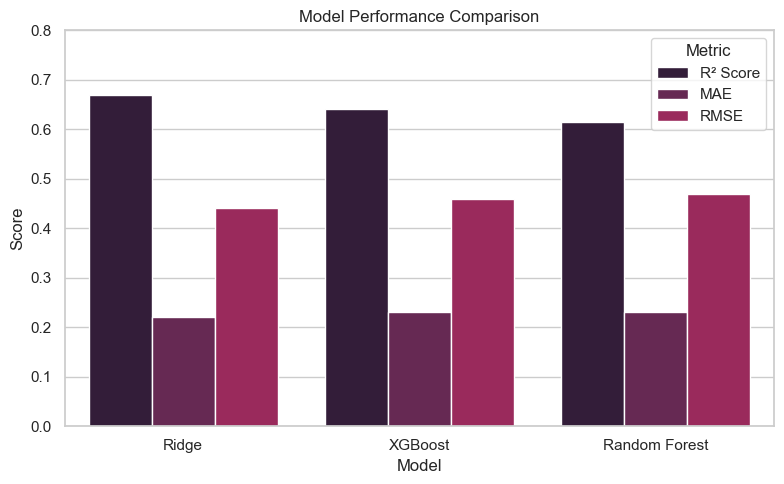

In [22]:
df_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Set seaborn style
sns.set(style="whitegrid")      
# Set the color palette
sns.set_palette("rocket")    

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df_melted, x='Model', y='Value', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 0.8)
plt.tight_layout()
plt.show()

Ridge Regression is the best model overall, achieving the highest R² score and the lowest MAE and RMSE, indicating it predicts most accurately with the least error across all metrics.

In [23]:
#tuning

xgb_pipeline = Pipeline([
    ('preprocessing', preprocessor),             
    ('drop_constant', VarianceThreshold(0.01)),  
    ('regressor', XGBRegressor(random_state=42)) 
])
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.05],
    'regressor__max_depth': [3, 4]
}

grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
print("Best XGBoost Params:", grid_search.best_params_)


y_pred_tuned = best_xgb.predict(X_test)
print("Tuned XGBoost Performance:")
print("R²:", round(r2_score(y_test, y_pred_tuned), 4))
print("MAE:", round(mean_absolute_error(y_test, y_pred_tuned), 4))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_tuned)), 4))

Best XGBoost Params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
Tuned XGBoost Performance:
R²: 0.6659
MAE: 0.2207
RMSE: 0.442


In [24]:
pipe 

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children',
                                                   'age_smoker',
                                                   'bmi_smoker']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'smoker', 'region',
                                                   'bmi_category',
                                                   'age_group'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

Model Explainability with SHAP

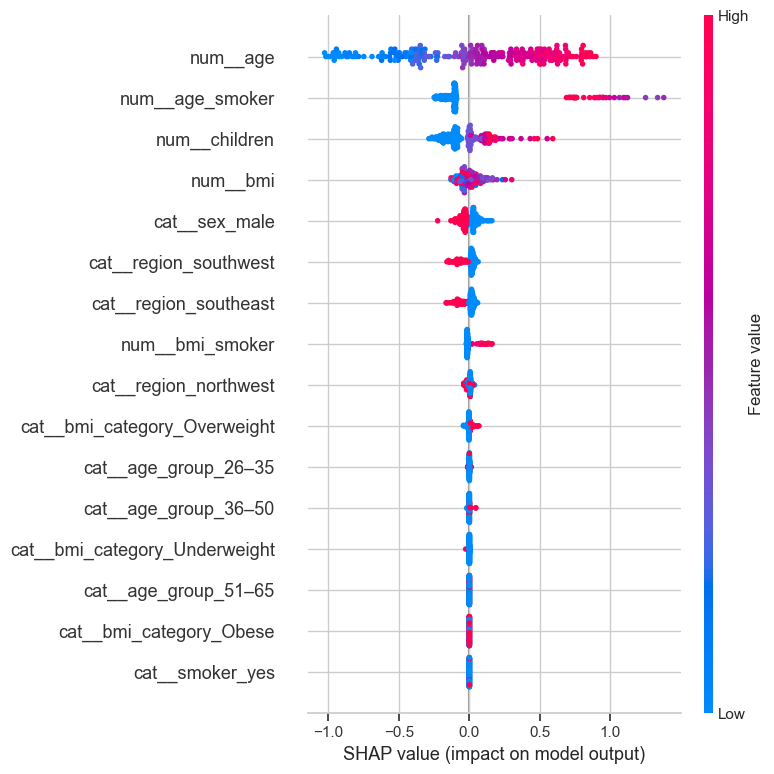

In [25]:
# Assign the best performing pipeline 
best_xgb = pipelines['XGBoost']

# Fit explainer on the model inside the pipeline
# We extract the regressor and the transformed data
xgb_model = best_xgb.named_steps['regressor']
X_test_transformed = best_xgb.named_steps['preprocessing'].transform(X_test)

# Use TreeExplainer for XGBoost
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_transformed)

# SHAP Summary Plot
shap.summary_plot(shap_values, features=X_test_transformed,
                  feature_names=best_xgb.named_steps['preprocessing'].get_feature_names_out())

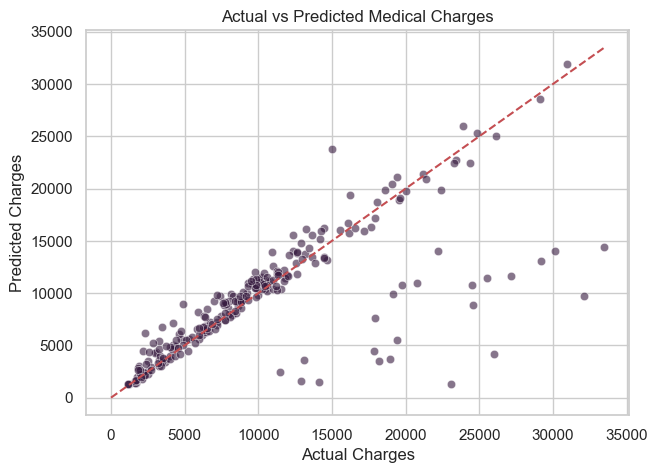

In [26]:
#actual vs predicted

y_pred = best_xgb.predict(X_test)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=np.expm1(y_test), y=np.expm1(y_pred), alpha=0.6)
plt.plot([0, max(np.expm1(y_test))], [0, max(np.expm1(y_test))], 'r--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Medical Charges")
plt.show()

Predicting Medical Insurance Charges for New Applicants

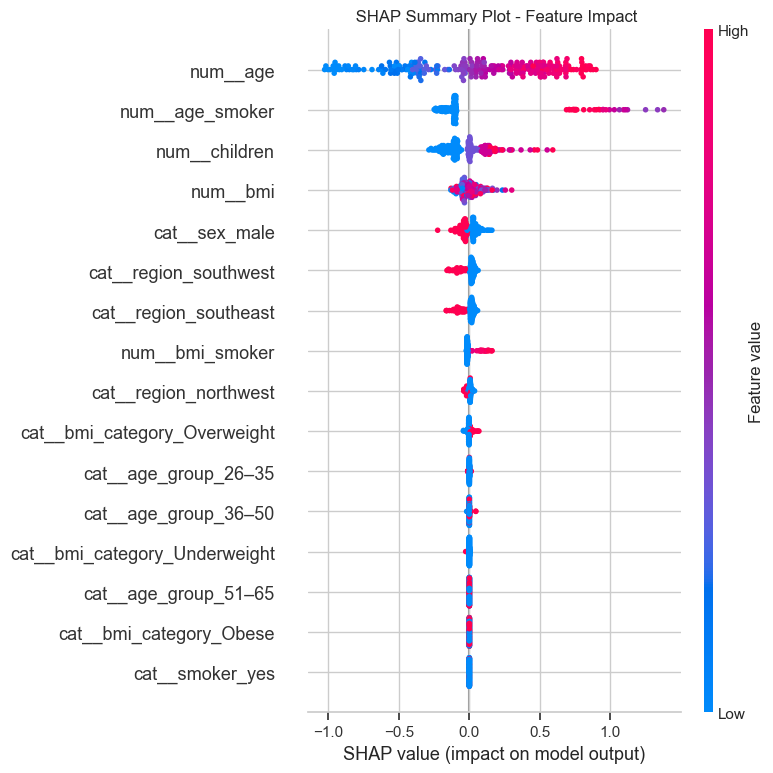

In [27]:



# 1. Extract model and transformed test data from the pipeline
xgb_model = best_xgb.named_steps['regressor']
X_test_transformed = best_xgb.named_steps['preprocessing'].transform(X_test)
feature_names = best_xgb.named_steps['preprocessing'].get_feature_names_out()

# 2. Initialize SHAP explainer for tree-based models (like XGBoost)
explainer = shap.Explainer(xgb_model)

# 3. Calculate SHAP values
shap_values = explainer(X_test_transformed)

# 4. Summary plot — feature importance + impact
plt.title(" SHAP Summary Plot - Feature Impact")
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names)


In [28]:
#def predict_insurance_charge(model):
#    import pandas as pd
#    import numpy as np

#    print("🔮 Predict Medical Insurance Charges")
#    #user input
#    age = int(input("Enter age: "))
#    sex = input("Enter sex (male/female): ").lower()
#    bmi = float(input("Enter BMI: "))
#    children = int(input("Number of children: "))
#    smoker = input("Smoker? (yes/no): ").lower()
#    region = input("Region (northeast/northwest/southeast/southwest): ").lower()

    #derived features
#    bmi_category = (
#        'Underweight' if bmi < 18.5 else
#        'Normal' if bmi < 25 else
#        'Overweight' if bmi < 30 else
#        'Obese'
#    )
#    age_group = (
#        '18–25' if age <= 25 else
#        '26–35' if age <= 35 else
#        '36–50' if age <= 50 else
#        '51–65'
 #   )
#    age_smoker = age if smoker == 'yes' else 0
 #   bmi_smoker = bmi if smoker == 'yes' else 0

    #Create DataFrame
  #  input_df = pd.DataFrame({
   #     'age': [age],
  #      'sex': [sex],
  #      'bmi': [bmi],
  #      'children': [children],
  #      'smoker': [smoker],
  #      'region': [region],
#     'bmi_category': [bmi_category],
#        'age_group': [age_group],
#        'age_smoker': [age_smoker],
#        'bmi_smoker': [bmi_smoker]
#    })

    # Predict
#    log_pred = model.predict(input_df)
#    final_prediction = np.expm1(log_pred[0])

#    print(f"\n💰 Estimated Medical Insurance Charge: {final_prediction:,.2f}")

In [29]:
#Run the prediction function
#predict_insurance_charge(best_xgb)

In [30]:
import os
import joblib

# ✅ Save your model directly in the current directory
joblib.dump(best_xgb, "model.pkl")
print("✅ Model saved as model.pkl in current folder")


✅ Model saved as model.pkl in current folder
